In [8]:
#import necessary libraries
import xarray as xr
from netCDF4 import Dataset, MFDataset, num2date
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import Proj
import geopandas as gpd


In [14]:
baseline = xr.open_dataset('201607_averaged.nc', drop_variables=['COL','ROW'])


def add_pm25(dataset):
    # Extract variables representing PM2.5 components
    pm25_components = ['PAL', 'PCA', 'PCL', 'PEC', 'PFE', 'PH2O', 'PK', 'PMG', 'PMN', 'PMOTHR', 'PNA', 'PNCOM', 'PNH4', 'PNO3', 'POC', 'PSI', 'PSO4', 'PTI']
    pm25_concentrations = dataset[pm25_components]

    # Sum up the concentrations along the specified dimensions (if necessary)
    # Access the variables you want to sum
    #PSO4', 'PNO3', 'POC', 'PEC', 'PNH4',
    pm25_total =  pm25_concentrations.variables[pm25_components[0]]
    for component in pm25_components[1:]:
        pm25_total += pm25_concentrations.variables[component]
        
    # Sum the emissions for each grid cell across the variables
    #pm25_total = var1+ var2 + var3 + var4 + var5

    # # Create a new variable for PM2.5 total and assign the calculated values to it
    dataset['PM25_total'] = pm25_total

    # Optionally, you can add attributes to the new variable to provide metadata
    dataset['PM25_total'].attrs['long_name'] = 'PM25_total'
    dataset['PM25_total'].attrs['units'] = 'g/s'
    dataset['PM25_total'].attrs['var_desc'] = 'Total PM2.5 concentration'
    return dataset

baseline = add_pm25(baseline)

In [15]:
from shapely.geometry import Polygon
import numpy as np

# Projection parameters
proj_params = {'proj': 'lcc',
               'lat_1': 33,
               'lat_2': 45,
               'lon_0': -97,
               'lat_0': 40}

# Coordinates of the origin
xorig = -2292000
yorig = -1584000

# Number of grid cells in x and y directions
num_cells_x = 1155
num_cells_y = 726

# Size of each grid cell (in meters)
cell_size = 4000  # 4km

# Generate grid coordinates using NumPy
x_coords = np.linspace(xorig, xorig + cell_size * num_cells_x, num_cells_x + 1)
y_coords = np.linspace(yorig, yorig + cell_size * num_cells_y, num_cells_y + 1)

# Create vertices for all grid cells using NumPy
x1, y1 = np.meshgrid(x_coords[:-1], y_coords[:-1])
x2, y2 = np.meshgrid(x_coords[1:], y_coords[:-1])
x3, y3 = np.meshgrid(x_coords[1:], y_coords[1:])
x4, y4 = np.meshgrid(x_coords[:-1], y_coords[1:])

# Reshape to 1D arrays
x1, x2, x3, x4 = x1.ravel(), x2.ravel(), x3.ravel(), x4.ravel()
y1, y2, y3, y4 = y1.ravel(), y2.ravel(), y3.ravel(), y4.ravel()

# Create GeoDataFrame with polygons
polygons = [Polygon([(x1[i], y1[i]), (x2[i], y2[i]), (x3[i], y3[i]), (x4[i], y4[i])]) for i in range(len(x1))]
grid_gdf = gpd.GeoDataFrame(geometry=polygons, crs=proj_params)

def to_flat_nd(ds):
    nd = ds['PM25_total'][0,0,:,:].to_numpy()
    nd_flat = nd.ravel()
    return nd_flat

grid_gdf['pm25'] = to_flat_nd(baseline)

In [20]:
census_tract_shapefiles = gpd.read_file("../SMOKE_sensitivity_analyses/US_census_shapefiles/US_tract_2018.shp")
census_tract_shapefiles = census_tract_shapefiles.loc[census_tract_shapefiles['STATEFP'] == "48"]
census_tract_shapefiles = census_tract_shapefiles.to_crs(grid_gdf.crs)

In [27]:
grid_gdf = grid_gdf.reset_index().rename(columns={'index': 'iD'})
census_tract_shapefiles_shapes = census_tract_shapefiles[['GISJOIN','geometry']]
intersection = gpd.overlay(grid_gdf, census_tract_shapefiles_shapes, how='intersection')

In [28]:
# intersecting polygons shapefile
# get pm values distributed to intersecting polygons
intersection['fraction'] = intersection.geometry.area/(4000 ** 2)
intersection['pm25_mod'] = intersection['pm25'] * intersection['fraction']
summed_df = intersection.groupby('GISJOIN')[['pm25_mod']  ].sum().reset_index()
census_tract_gdf = summed_df.merge(census_tract_shapefiles, how='left', 
                       left_on='GISJOIN', right_on='GISJOIN')

In [36]:
census_tract_gdf.to_csv("census_tract_pm25_emissions_july.csv")

# get census tract level emissions

In [1]:
#import necessary libraries
import xarray as xr
from netCDF4 import Dataset, MFDataset, num2date
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import Proj

In [2]:
pwd

'/home/ksz4578/Heat_Pump_Project/WRF_analyses'

In [4]:
# the two components of emissions data
rwc_2020 = xr.open_dataset('../SMOKE_sensitivity_analyses/rwc_2020_201601_avg.nc')
rwc_2016 = xr.open_dataset('../SMOKE_sensitivity_analyses/201601_diff_no_rwc.nc')
rwc_2020_new_surg = xr.open_dataset("../SMOKE_sensitivity_analyses/2020_new_surrogates_avg.nc")

In [5]:
def add_pm25(dataset):
    # Extract variables representing PM2.5 components
    pm25_components = ['PAL', 'PCA', 'PCL', 'PEC', 'PFE', 'PH2O', 'PK', 'PMG', 'PMN', 'PMOTHR', 'PNA', 'PNCOM', 'PNH4', 'PNO3', 'POC', 'PSI', 'PSO4', 'PTI']
    pm25_concentrations = dataset[pm25_components]

    # Sum up the concentrations along the specified dimensions (if necessary)
    # Access the variables you want to sum
    #PSO4', 'PNO3', 'POC', 'PEC', 'PNH4',
    pm25_total =  pm25_concentrations.variables[pm25_components[0]]
    for component in pm25_components[1:]:
        pm25_total += pm25_concentrations.variables[component]
        
    # Sum the emissions for each grid cell across the variables
    #pm25_total = var1+ var2 + var3 + var4 + var5

    # # Create a new variable for PM2.5 total and assign the calculated values to it
    dataset['PM25_total'] = pm25_total

    # Optionally, you can add attributes to the new variable to provide metadata
    dataset['PM25_total'].attrs['long_name'] = 'PM25_total'
    dataset['PM25_total'].attrs['units'] = 'g/s'
    dataset['PM25_total'].attrs['var_desc'] = 'Total PM2.5 concentration'
    return dataset

rwc_2020_new_surg = add_pm25(rwc_2020_new_surg)
rwc_2020 = add_pm25(rwc_2020)
rwc_2016 = add_pm25(rwc_2016)

In [6]:
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np

# Projection parameters
proj_params = {'proj': 'lcc',
               'lat_1': 33,
               'lat_2': 45,
               'lon_0': -97,
               'lat_0': 40}

# Coordinates of the origin
xorig = -2292000
yorig = -1584000

# Number of grid cells in x and y directions
num_cells_x = 1155
num_cells_y = 726

# Size of each grid cell (in meters)
cell_size = 4000  # 4km

# Generate grid coordinates using NumPy
x_coords = np.linspace(xorig, xorig + cell_size * num_cells_x, num_cells_x + 1)
y_coords = np.linspace(yorig, yorig + cell_size * num_cells_y, num_cells_y + 1)

# Create vertices for all grid cells using NumPy
x1, y1 = np.meshgrid(x_coords[:-1], y_coords[:-1])
x2, y2 = np.meshgrid(x_coords[1:], y_coords[:-1])
x3, y3 = np.meshgrid(x_coords[1:], y_coords[1:])
x4, y4 = np.meshgrid(x_coords[:-1], y_coords[1:])

# Reshape to 1D arrays
x1, x2, x3, x4 = x1.ravel(), x2.ravel(), x3.ravel(), x4.ravel()
y1, y2, y3, y4 = y1.ravel(), y2.ravel(), y3.ravel(), y4.ravel()

# Create GeoDataFrame with polygons
polygons = [Polygon([(x1[i], y1[i]), (x2[i], y2[i]), (x3[i], y3[i]), (x4[i], y4[i])]) for i in range(len(x1))]
grid_gdf = gpd.GeoDataFrame(geometry=polygons, crs=proj_params)



In [ ]:
census_tract_shapefiles = gpd.read_file("../SMOKE_sensitivity_analyses/US_census_shapefiles/US_tract_2018.shp")
census_tract_shapefiles = census_tract_shapefiles.to_crs(grid_gdf.crs)

In [7]:
import geopandas as gpd
census_tract_shapefiles = gpd.read_file("../SMOKE_sensitivity_analyses/US_census_shapefiles/US_tract_2018.shp")
census_tract_shapefiles = census_tract_shapefiles.to_crs(grid_gdf.crs)

In [8]:
def to_flat_nd(ds):
    nd = ds['PM25_total'][0,0,:,:].to_numpy()
    nd_flat = nd.ravel()
    return nd_flat

grid_gdf['pm_2020_new'] = to_flat_nd(rwc_2020_new_surg)
grid_gdf['pm_2020'] = to_flat_nd(rwc_2020)
grid_gdf['pm_2016'] = to_flat_nd(rwc_2016)

In [9]:
grid_gdf = grid_gdf.reset_index().rename(columns={'index': 'iD'})
census_tract_shapefiles_shapes = census_tract_shapefiles[['GISJOIN','geometry']]
intersection = gpd.overlay(grid_gdf, census_tract_shapefiles_shapes, how='intersection')
#intersection.to_file("intersection.shp")

In [ ]:
intersection.to_file("intersection.shp")

In [10]:
intersection.head()

,iD,pm_2020_new,pm_2020,pm_2016,GISJOIN,geometry
0,964,0.000000,0.0,0.0,G1200870972500,"POLYGON ((1568000.000 -1580351.339, 1568000.00..."
1,965,0.001561,0.0,0.0,G1200870972500,"MULTIPOLYGON (((1569803.906 -1580000.000, 1569..."
2,2120,0.000000,0.0,0.0,G1200870972500,"POLYGON ((1569906.927 -1580000.000, 1569803.90..."
3,965,0.001561,0.0,0.0,G1200870972100,"MULTIPOLYGON (((1571199.795 -1584000.000, 1570..."
4,967,0.004344,0.0,0.0,G1200870971700,"MULTIPOLYGON (((1580000.000 -1582919.694, 1580..."


In [11]:
# intersecting polygons shapefile
# get pm values distributed to intersecting polygons
intersection['fraction'] = intersection.geometry.area/(4000 ** 2)
intersection['per_2020_new'] = intersection['pm_2020_new'] * intersection['fraction']
intersection['per_2020'] = intersection['pm_2020'] * intersection['fraction']
intersection['per_2016'] = intersection['pm_2016'] * intersection['fraction']

In [12]:
summed_df = intersection.groupby('GISJOIN')[['per_2020_new', 'per_2020', 'per_2016']  ].sum().reset_index()

In [13]:
summed_df.to_csv("census_tract_pm25_emissions.csv")

In [14]:
summed_df['2020_per_area'] = 

,GISJOIN,per_2020_new,per_2020,per_2016
0,G0100010020100,0.089498,0.066077,0.129428
1,G0100010020200,0.035834,0.051790,0.103306
2,G0100010020300,0.051106,0.090658,0.182272
3,G0100010020400,0.070943,0.116995,0.234298
4,G0100010020500,0.064307,0.087117,0.186118
...,...,...,...,...
72258,G5600430000200,2.283168,2.588662,0.667095
72259,G5600430000301,0.107008,0.047372,0.012258
72260,G5600430000302,0.546806,0.258931,0.066999
72261,G5600450951100,1.908171,1.895158,0.571147


In [15]:
census_tract_gdf = summed_df.merge(census_tract_shapefiles, how='left', 
                       left_on='GISJOIN', right_on='GISJOIN')
census_tract_gdf = census_tract_gdf.rename(columns={
           "ALUKE001":    "Total",
           "ALUKE003":    "White",
           "ALUKE004":    "Black",
           "ALUKE005":    "American Indian",
           "ALUKE006":    "Asian",
           "ALUKE007":    "Native Hawaiian and Other Pacific Islander",
           "ALUKE008":    "Some Other Race",
           "ALUKE009":    "Two or More Races",
           "ALUKE010":    "Two or More Races: Two races including Some Other Race",
           "ALUKE011":    "Two or More Races: Two races excluding Some Other Race, and three or more races",
           'ALUKE012': 'Hispanic or Latino',
           'ALUKE013': 'Hispanic or Latino: White alone',
           'ALUKE014': 'Hispanic or Latino: Black or African American alone',
           'ALUKE015': 'Hispanic or Latino: American Indian and Alaska Native alone',
           'ALUKE016': 'Hispanic or Latino: Asian alone',
           'ALUKE017': 'Hispanic or Latino: Native Hawaiian and Other Pacific Islander alone',
           'ALUKE018': 'Hispanic or Latino: Some other race alone',
           'ALUKE019': 'Hispanic or Latino: Two or more races',
           'ALUKE020': 'Hispanic or Latino: Two or more races: Two races including Some other race',
           'ALUKE021': 'Hispanic or Latino: Two or more races: Two races excluding Some other race, and three or more races'
                   })

In [18]:
census_tract_gdf = census_tract_gdf.rename(columns={
    "Total":"Total",
    "White alone":"White",
    "Black or African American alone":"Black",
    "American Indian and Alaska Native alone":"American Indian",
    "Asian alone":"Asian",
    "Native Hawaiian and Other Pacific Islander alone":"Native Hawaiian and Other Pacific Islander",
    "Some Other Race alone":"Other"
})


In [21]:
census_tract_gdf['2020_new_per_area'] = census_tract_gdf['per_2020_new'] / census_tract_gdf['Shape_Area'] * 1000000
census_tract_gdf['2020_per_area'] = census_tract_gdf['per_2020'] / census_tract_gdf['Shape_Area'] * 1000000
census_tract_gdf['2016_per_area'] = census_tract_gdf['per_2016'] / census_tract_gdf['Shape_Area'] * 1000000

In [29]:
census_tract_gdf.to_file("census_tract_pm25_emissions.shp")

/tmp/ipykernel_207332/1479870593.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  census_tract_gdf.to_file("census_tract_pm25_emissions.shp")


In [25]:
census_tract_gdf = gpd.GeoDataFrame(census_tract_gdf, geometry='geometry')

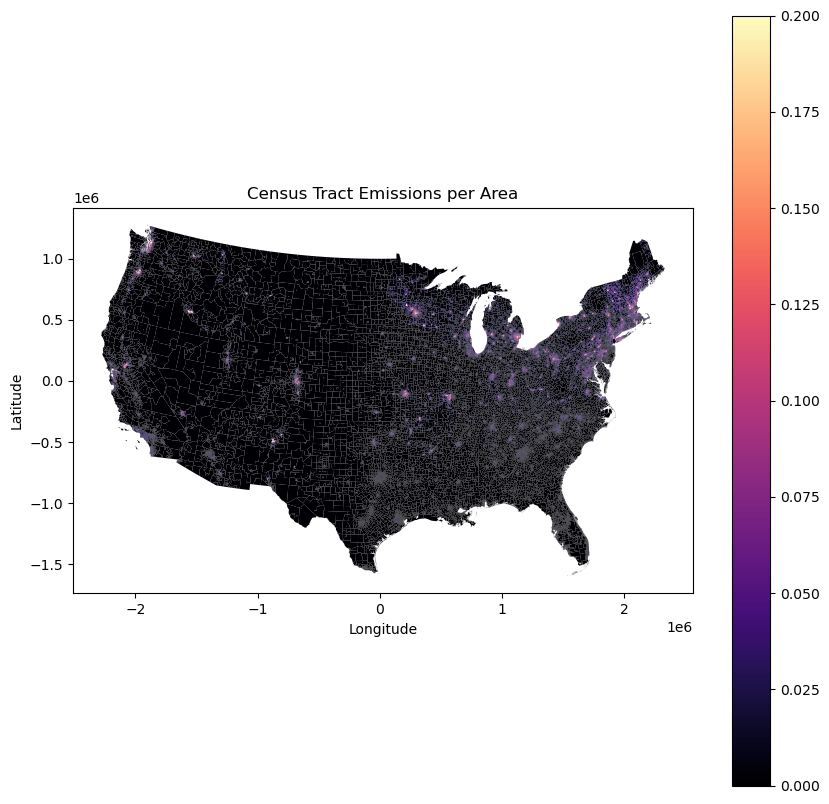

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)

# Set the colorbar limits here
census_tract_gdf.plot(column = "2020_new_per_area", cmap='magma', legend=True, ax = ax, vmin = 0, vmax = 0.2)


# Step 4: Customizing plot attributes
plt.title('Census Tract Emissions per Area')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gcf().set_size_inches(10, 10)  # Set figure size (width, height) in inches
plt.show()

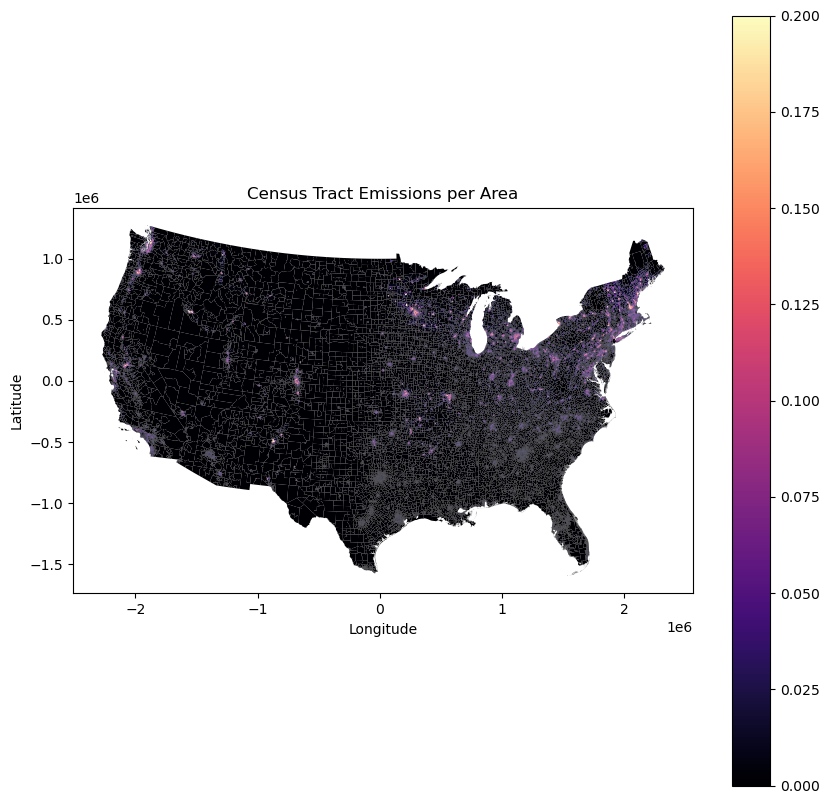

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)

# Set the colorbar limits here
census_tract_gdf.plot(column = "2020_per_area", cmap='magma', legend=True, ax = ax, vmin = 0, vmax = 0.2)


# Step 4: Customizing plot attributes
plt.title('Census Tract Emissions per Area')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gcf().set_size_inches(10, 10)  # Set figure size (width, height) in inches
plt.show()

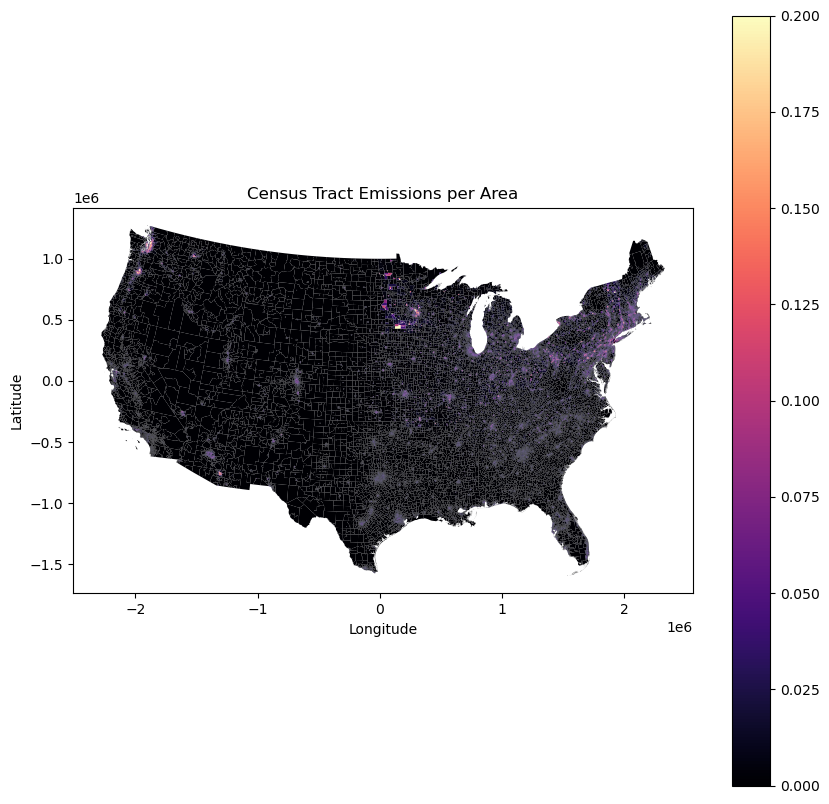

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)

# Set the colorbar limits here
census_tract_gdf.plot(column = "2016_per_area", cmap='magma', legend=True, ax = ax, vmin = 0, vmax = 0.2)


# Step 4: Customizing plot attributes
plt.title('Census Tract Emissions per Area')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gcf().set_size_inches(10, 10)  # Set figure size (width, height) in inches
plt.show()

# get census tract level concentrations

In [1]:
#import necessary libraries
import xarray as xr
from netCDF4 import Dataset, MFDataset, num2date
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import Proj

In [2]:
import pandas as pd
census_tract_df = pd.read_csv('census_tract_race.csv', header = 0, encoding='latin1')
census_tract_df.drop(['YEAR',
                      'COUSUBA',
                      'PLACEA',
                      'BLKGRPA',
                      'CONCITA',
                      'AIANHHA',
                      'RES_ONLYA',
                      'TRUSTA',
                      'AIHHTLI',
                      'ANRCA',
                      'NECTAA',
                      'CNECTAA',
                      'NECTADIVA',
                      'CDCURRA',
                    'SLDUA',
                    'SLDLA',
                    'ZCTA5A',
                    'SUBMCDA',
                    'SDELMA',
                    'SDSECA',
                    'SDUNIA',
                    'PCI',
                    'PUMAA',
                    'BTBGA'], axis=1, inplace=True)

In [4]:
import geopandas as gpd
gdf = gpd.read_file("../SMOKE_sensitivity_analyses/US_census_shapefiles/US_tract_2018.shp")

In [5]:
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np

# Projection parameters
proj_params = {'proj': 'lcc',
               'lat_1': 33,
               'lat_2': 45,
               'lon_0': -97,
               'lat_0': 40}

# Coordinates of the origin
xorig = -2292000
yorig = -1584000

# Number of grid cells in x and y directions
num_cells_x = 1155
num_cells_y = 726

# Size of each grid cell (in meters)
cell_size = 4000  # 4km

# Generate grid coordinates using NumPy
x_coords = np.linspace(xorig, xorig + cell_size * num_cells_x, num_cells_x + 1)
y_coords = np.linspace(yorig, yorig + cell_size * num_cells_y, num_cells_y + 1)

# Create vertices for all grid cells using NumPy
x1, y1 = np.meshgrid(x_coords[:-1], y_coords[:-1])
x2, y2 = np.meshgrid(x_coords[1:], y_coords[:-1])
x3, y3 = np.meshgrid(x_coords[1:], y_coords[1:])
x4, y4 = np.meshgrid(x_coords[:-1], y_coords[1:])

# Reshape to 1D arrays
x1, x2, x3, x4 = x1.ravel(), x2.ravel(), x3.ravel(), x4.ravel()
y1, y2, y3, y4 = y1.ravel(), y2.ravel(), y3.ravel(), y4.ravel()

# Create GeoDataFrame with polygons
polygons = [Polygon([(x1[i], y1[i]), (x2[i], y2[i]), (x3[i], y3[i]), (x4[i], y4[i])]) for i in range(len(x1))]
grid_gdf = gpd.GeoDataFrame(geometry=polygons, crs=proj_params)

In [6]:
baseline = xr.open_dataset("avg_201601.nc")
no_rwc = xr.open_dataset("no_rwc_avg_201601.nc")

In [7]:
census_tract_gdf = gdf.merge(census_tract_df, how='left', 
                       left_on='GISJOIN', right_on='GISJOIN')

# Projection parameters
proj_params = {'proj': 'lcc',
               'lat_1': 33,
               'lat_2': 45,
               'lon_0': -97,
               'lat_0': 40}

census_tract_gdf = census_tract_gdf.to_crs(proj_params) # convert to the same SMOKE CRS projection 

In [8]:
grid_gdf["PM25_no_rwc"] = no_rwc['PM25_TOT'][0,0,:,:].to_numpy().ravel()
grid_gdf["PM25_no_rwc_baseline"] = baseline['PM25_TOT'][0,0,:,:].to_numpy().ravel()
grid_gdf = grid_gdf.reset_index().rename(columns={'index': 'iD'})

In [ ]:
grid_gdf = grid_gdf.reset_index().rename(columns={'index': 'iD'})
census_tract_shapes = census_tract_gdf[['GISJOIN','geometry']]
intersection = gpd.overlay(grid_gdf, census_tract_shapes, how='intersection')
intersection.to_file("baseline_intersection_pm25.shp")